## **Machine Learning - Clasificación**

---
### **Librerías**

In [14]:
import warnings

warnings.filterwarnings("ignore")  # Suprime warnings

import pandas as pd
import numpy as np
import pickle
import os

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.experimental import enable_halving_search_cv  # Activa la funcionalidad experimental
from sklearn.model_selection import HalvingGridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns


---
### **1. Cargar dataset y definir `X` e `y`**

In [15]:
# Ruta de los outputs
input_folder = "../../data/outputs/3_eda"

# Cargar el DataFrame preprocesado que incluye el texto concatenado y la variable objetivo
texto_medicamentos_df = pd.read_csv(
    os.path.join(input_folder, "texto_concatenado_medicamentos.csv")
)
print("Columnas:", texto_medicamentos_df.columns.tolist())

# Aseguramos que la variable objetivo esté presente (por ejemplo, "descripcion_nivel_anatomico")
assert (
    "descripcion_nivel_anatomico" in texto_medicamentos_df.columns
), "No se encontró la variable objetivo."

output_folder = "../../images/classification/"
os.makedirs(output_folder, exist_ok=True)

Columnas: ['medicamento', 'descripcion_nivel_anatomico', 'descripcion_nivel_2_subgrupo_terapeutico', 'descripcion_nivel_3_subgrupo_terapeutico_farmacologico', 'descripcion_nivel_4_subgrupo_terapeutico_farmacologico_quimico', 'descripcion_nivel_5_principio_activo', 'texto_completo']


In [16]:
# Cargar el vectorizador TF-IDF y la matriz vectorizada
with open(os.path.join(input_folder, "tfidf_vectorizer.pkl"), "rb") as f:
    tfidf_vectorizer = pickle.load(f)

with open(os.path.join(input_folder, "tfidf_matrix.pkl"), "rb") as f:
    tfidf_matrix = pickle.load(f)

# Definir features (X) y variable objetivo (y)
X = tfidf_matrix  # Matriz TF-IDF
# Queremos predecir el nivel anatomico, es decir, sistema nervioso, digestivo, etc.
y = texto_medicamentos_df["descripcion_nivel_anatomico"]
# Rellenar valores nulos
y = y.fillna("Desconocido")

# Convertir categorías a valores numéricos
le = LabelEncoder()
y = le.fit_transform(y) # 1,2,3,4,5, ...
# categorias_originales = le.inverse_transform(y) # si queremos revertir la codificación

# Mostrar las clases y sus valores correspondientes
clases_originales = le.inverse_transform(np.unique(y))
print("Clases originales y sus valores:")
for valor, clase in enumerate(clases_originales):
    print(f"{valor}: {clase}")


Clases originales y sus valores:
0: Desconocido
1: antiinfecciosos para uso sistémico
2: antineoplásicos e inmunomoduladores
3: dermatológicos
4: preparados hormonales sistémicos, excluyendo hormonas sexuales e insulinas
5: productos antiparasitarios, insecticidas y repelentes
6: sangre y órganos hematopoyéticos
7: sistema cardiovascular
8: sistema digestivo y metabolismo
9: sistema genitourinario y hormonas sexuales
10: sistema musculoesquelético
11: sistema nervioso
12: sistema respiratorio
13: varios
14: órganos sensoriales


---
### **2. Devidir en `train` y `test`**

In [17]:
# Dividir en entrenamiento (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

---
### **3. Clasificación del `grupo anatómico` de los medicamentos**

---
### **3.1 Regresión logística (LR)**

---
##### **Entrenamiento**

In [5]:
# --- Regresión Logística ---
print("### Grid Search: Regresión Logística ###")

# Definir el grid de hiperparámetros. Por ejemplo, se puede optimizar el parámetro C
param_grid_lr = {
    "C": [100, 200, 500],
    "penalty": ["l2"],  # Para 'l1' se necesita solver 'liblinear'
    "solver": ["lbfgs"],  # lbfgs soporta multiclass
    "max_iter": [1000],
}

### Grid Search: Regresión Logística ###


In [6]:
lr = LogisticRegression(random_state=42)
grid_lr = GridSearchCV(lr,
                        param_grid_lr, 
                        cv=5, 
                        scoring="accuracy", 
                        n_jobs=10, 
                        return_train_score=True)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=10,
             param_grid={'C': [100, 200, 500], 'max_iter': [1000],
                         'penalty': ['l2'], 'solver': ['lbfgs']},
             return_train_score=True, scoring='accuracy')

In [7]:
print("Mejores hiperparámetros (LogReg):", grid_lr.best_params_)
print("Mejor CV Accuracy (LogReg): {:.2f}".format(grid_lr.best_score_))

Mejores hiperparámetros (LogReg): {'C': 500, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Mejor CV Accuracy (LogReg): 0.95


---
##### **Test**

In [8]:
# Evaluación en el conjunto de entrenamiento y test
best_lr = grid_lr.best_estimator_
y_train_pred_lr = best_lr.predict(X_train)
y_test_pred_lr = best_lr.predict(X_test)

print(
    "Regresión Logística - Train Accuracy: {:.2f}".format(
        accuracy_score(y_train, y_train_pred_lr)
    )
)
print(
    "Regresión Logística - Test Accuracy: {:.2f}".format(
        accuracy_score(y_test, y_test_pred_lr)
    )
)
print(
    "\nReporte de Clasificación - Regresión Logística (Test):\n",
    classification_report(y_test, y_test_pred_lr, zero_division=0),
)

Regresión Logística - Train Accuracy: 0.99
Regresión Logística - Test Accuracy: 0.95

Reporte de Clasificación - Regresión Logística (Test):
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       926
           1       0.94      0.98      0.96       241
           2       0.95      0.96      0.95       242
           3       0.89      0.94      0.91        84
           4       1.00      0.93      0.96        57
           5       0.50      0.50      0.50         6
           6       0.94      0.96      0.95       169
           7       0.98      0.98      0.98       667
           8       0.99      0.98      0.99       330
           9       0.96      0.94      0.95       184
          10       0.96      0.96      0.96       170
          11       0.97      0.97      0.97       895
          12       0.95      0.97      0.96       209
          13       0.93      0.93      0.93        71
          14       0.97      0.94      0.96    

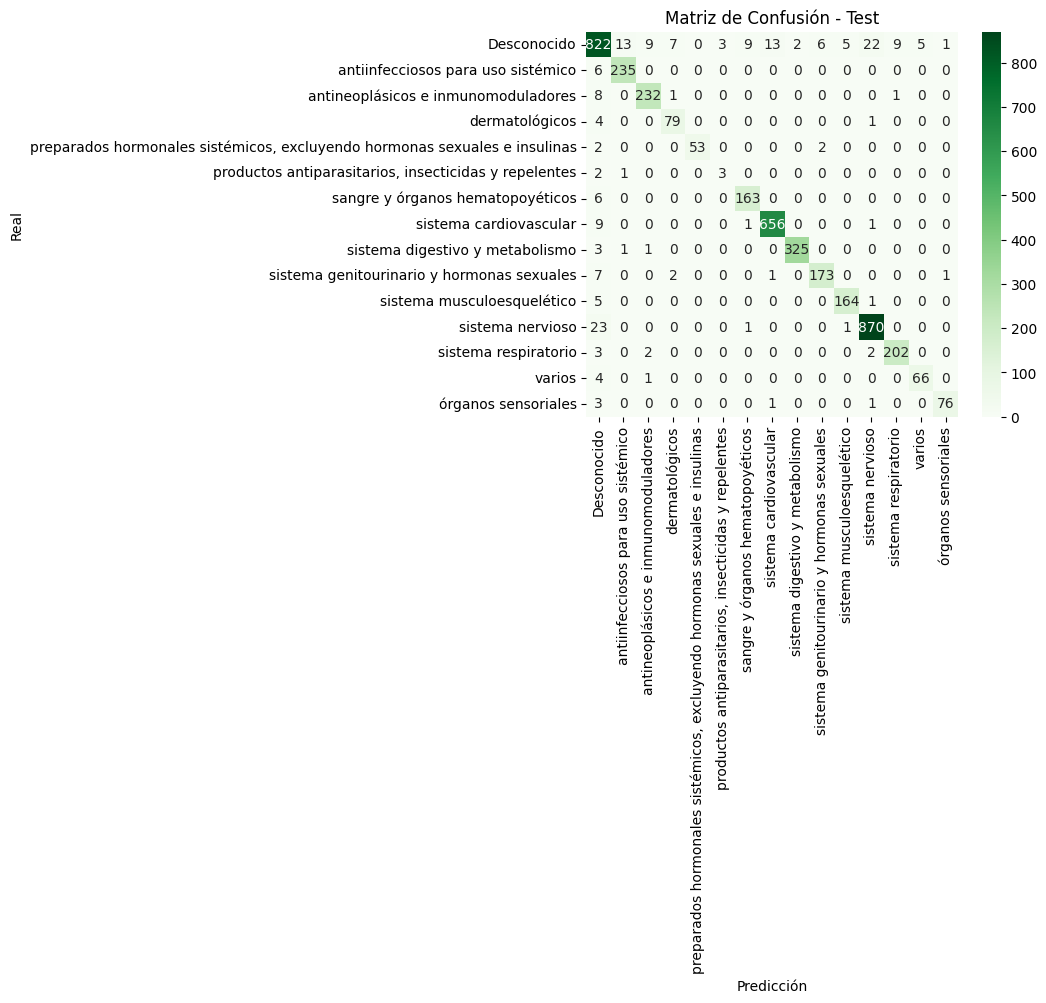

FileExistsError: [Errno 17] File exists: '../../images/classification/metrics_test_RL.png'

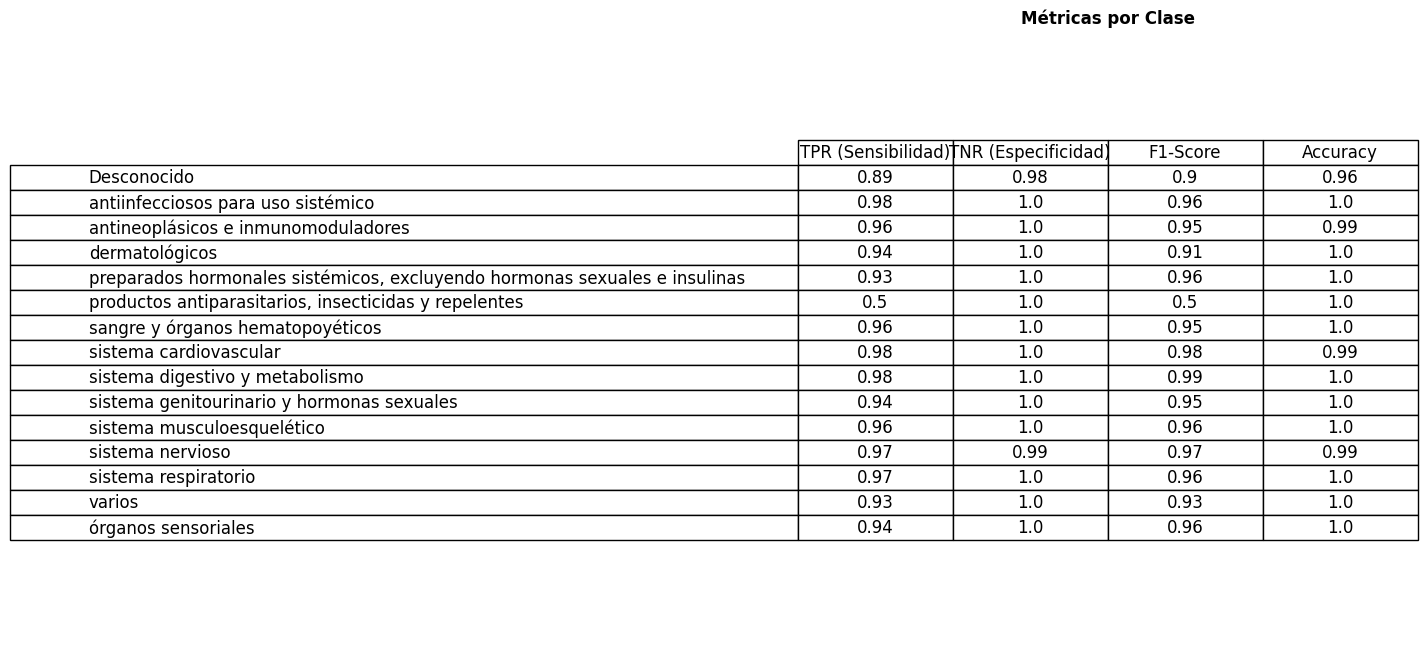

In [9]:
# Función para mostrar la matriz de confusión
def plot_test_confusion_matrix_metrics(y_test, y_pred_test, model):
    """
    Genera y muestra de forma visual la matriz de confusión para el conjunto de test y, en una figura aparte,
    muestra una tabla con los indicadores TPR (Sensibilidad), TNR (Especificidad), F1-Score y Accuracy para cada clase.
    
    Parámetros:
        y_test (array-like): Etiquetas reales del conjunto de test.
        y_pred_test (array-like): Predicciones del modelo sobre el conjunto de test.
        model (str): Nombre del modelo utilizado para la predicción (ej. "RL").
    
    Nota:
        Se asume que la variable global 'le' (LabelEncoder) ha sido definida y entrenada previamente
        para obtener los nombres originales de las clases.
    """

    # Calcular la matriz de confusión para test
    cm = confusion_matrix(y_test, y_pred_test)
    class_names = le.classes_
    n_classes = len(class_names)

    # Mostrar la matriz de confusión con ejes ordenados
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión - Test')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.xticks(rotation=90)
    plt.tight_layout()
    # Crear el directorio de salida si no existe
    final_output_path = os.path.join(output_folder, f"matriz_confusion_test_{model}.png")
    os.makedirs(output_folder, exist_ok=True)
    plt.savefig(final_output_path, bbox_inches='tight')
    plt.show()

    # Calcular métricas por clase
    metrics = {"Clase": [], "TPR (Sensibilidad)": [], "TNR (Especificidad)": [], "F1-Score": [], "Accuracy": []}
    total = cm.sum()
    for i in range(n_classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = total - (TP + FN + FP)
        
        tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
        tnr = TN / (TN + FP) if (TN + FP) > 0 else 0
        f1 = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
        acc = (TP + TN) / total if total > 0 else 0
        
        metrics["Clase"].append(class_names[i])
        metrics["TPR (Sensibilidad)"].append(round(tpr, 2))
        metrics["TNR (Especificidad)"].append(round(tnr, 2))
        metrics["F1-Score"].append(round(f1, 2))
        metrics["Accuracy"].append(round(acc, 2))
    
    df_metrics = pd.DataFrame(metrics).set_index("Clase")
    
    # Visualizar la tabla de métricas
    fig, ax = plt.subplots(figsize=(8, 0.5 + 0.5 * n_classes))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df_metrics.values,
                     colLabels=df_metrics.columns,
                     rowLabels=df_metrics.index,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    plt.title("Métricas por Clase", fontweight="bold")
    plt.tight_layout()
    # Crear el directorio de salida si no existe
    final_output_path = os.path.join(output_folder, f"metrics_test_{model}.png")
    os.makedirs(final_output_path, exist_ok=True)
    plt.savefig(final_output_path, bbox_inches='tight')
    plt.show()

# Matriz de confusión de la regresión logística
plot_test_confusion_matrix_metrics(y_test, y_test_pred_lr, 'RL')

---
#### **3.2 Random Forest (RF)**

---
##### **Entrenamiento**

In [18]:
# --- RandomForest ---
print("\n### Grid Search: RandomForestClassifier ###")

param_grid_rf = {
    "n_estimators": [100, 200, 300],          # Número de árboles en el bosque
    "max_depth": [None, 10, 20, 30],            # Profundidad máxima de cada árbol
    "min_samples_split": [2, 5, 10],            # Número mínimo de muestras para dividir un nodo
    "min_samples_leaf": [1, 2, 4],              # Número mínimo de muestras que debe tener una hoja
    "max_features": ["sqrt", "log2", None],     # Número de características a considerar para la mejor división
    "bootstrap": [True, False],               # Si se usa muestreo con reemplazo o no
    "criterion": ["gini", "entropy"],         # Función de evaluación de la división
    "max_leaf_nodes": [None, 50, 100]           # Número máximo de nodos hoja en cada árbol
}


### Grid Search: RandomForestClassifier ###


In [19]:
rf = RandomForestClassifier(random_state=42)
grid_rf = HalvingGridSearchCV(rf, 
                              param_grid_rf, 
                              cv=5, 
                              scoring="accuracy", 
                              n_jobs=-1)
grid_rf.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print("Mejores hiperparámetros (RF):", grid_rf.best_params_)
print("Mejor CV Accuracy (RF): {:.2f}".format(grid_rf.best_score_))

Mejores hiperparámetros (RF): {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
Mejor CV Accuracy (RF): 0.96


---
##### **Test**

In [14]:
# Evaluación en el conjunto de entrenamiento y test
best_rf = grid_rf.best_estimator_
y_train_pred_rf = best_rf.predict(X_train)
y_test_pred_rf = best_rf.predict(X_test)

print(
    "RandomForest - Train Accuracy: {:.2f}".format(
        accuracy_score(y_train, y_train_pred_rf)
    )
)
print(
    "RandomForest - Test Accuracy: {:.2f}".format(
        accuracy_score(y_test, y_test_pred_rf)
    )
)
print(
    "\nReporte de Clasificación - RandomForest (Test):\n",
    classification_report(y_test, y_test_pred_rf, zero_division=0),
)

RandomForest - Train Accuracy: 1.00
RandomForest - Test Accuracy: 0.96

Reporte de Clasificación - RandomForest (Test):
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       926
           1       0.93      1.00      0.96       241
           2       0.98      0.99      0.98       242
           3       0.85      0.95      0.90        84
           4       0.98      0.98      0.98        57
           5       0.60      0.50      0.55         6
           6       0.97      0.99      0.98       169
           7       0.99      0.99      0.99       667
           8       0.99      1.00      0.99       330
           9       0.98      0.97      0.98       184
          10       0.96      0.97      0.97       170
          11       0.97      0.98      0.98       895
          12       0.97      0.97      0.97       209
          13       0.95      0.85      0.90        71
          14       0.97      0.95      0.96        81

    accuracy 

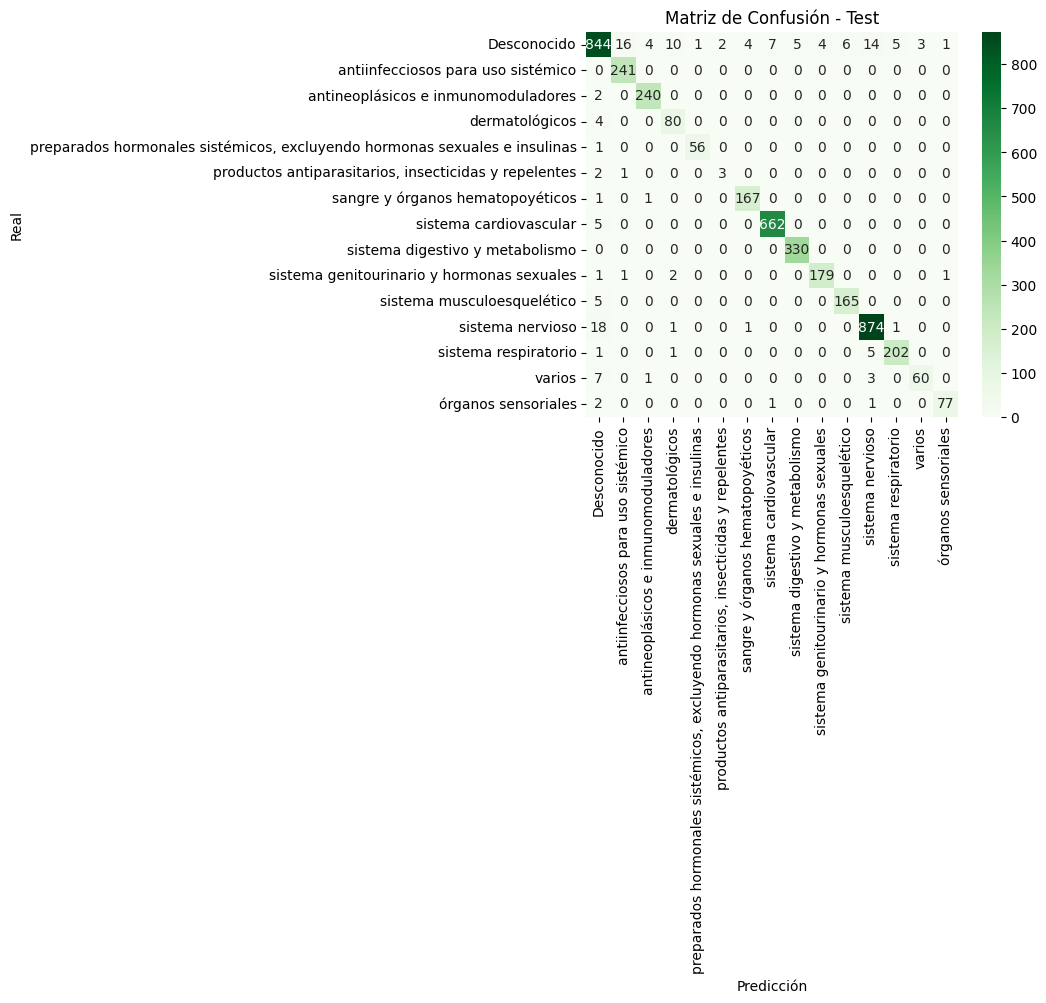

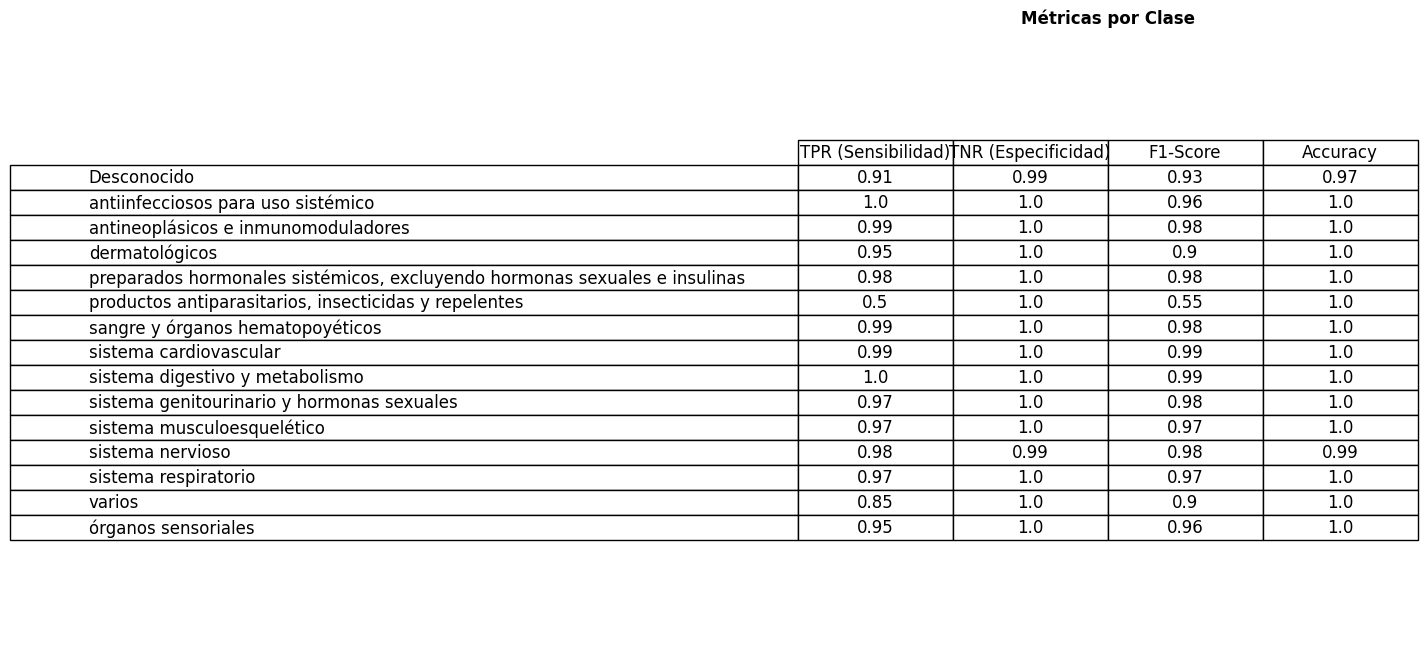

In [15]:
# Matriz de confusión de la random forest
plot_test_confusion_matrix_metrics(y_test, y_test_pred_rf, 'RF')

---
### **4. Análisis de explicabilidad de los modelos**

In [16]:
############################################
# 2. Interpretabilidad: Variables Explicativas #
############################################

# --- Para Regresión Logística ---
# Extraer coeficientes: best_lr.coef_ tiene forma (n_clases, n_features)
feature_names = tfidf_vectorizer.get_feature_names_out()
coef = best_lr.coef_
# Por ejemplo, para cada clase mostramos las 10 características con coeficiente más alto
print("\nTop características por clase (Regresión Logística):")
important_words_by_class = {}
for idx, class_label in enumerate(best_lr.classes_):
    coef_class = coef[idx]
    # Ordenar índices de mayor a menor
    top10_idx = np.argsort(coef_class)[-10:]
    top_features = feature_names[top10_idx]
    top_coef = coef_class[top10_idx]
    class_name = clases_originales[class_label]  # Obtener el nombre de la clase
    print(f"\nClase: {class_label} ({class_name})")
    important_words_by_class[class_name] = []
    for feat, coef_val in zip(top_features[::-1], top_coef[::-1]):
        print(f"{feat}: {coef_val:.4f}")
        important_words_by_class[class_name].append(feat)

# --- Para RandomForest ---
# Extraer feature_importances_
importances = best_rf.feature_importances_
indices_rf = np.argsort(importances)[-10:]
print("\nTop características (RandomForest):")
for idx in indices_rf[::-1]:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")


Top características por clase (Regresión Logística):

Clase: 0 (Desconocido)
basal: 13.1345
social: 9.4418
ic: 9.2303
mg mg: 9.0569
tev: 8.6883
er: 8.6172
período: 8.1445
mg etoricoxib: 7.7179
hba: 7.5473
tel: 7.3768

Clase: 1 (antiinfecciosos para uso sistémico)
sistémico antibacterianos: 26.2568
antibacterianos: 25.0585
sistémico: 22.3107
antiinfecciosos: 19.7095
ritonavir: 8.8658
macrólidos: 7.8907
caspofungina: 7.5311
entecavir: 7.2343
micafungina: 7.2051
daptomicina: 7.1551

Clase: 2 (antineoplásicos e inmunomoduladores)
antineoplásicos: 28.0870
inmunomoduladores: 18.5622
inmunosupresores: 12.5560
lmc: 9.0142
bosutinib: 7.1451
anastrozol: 6.9594
ciclosporina: 6.9444
letrozol: 6.6746
pirfenidona: 6.6626
anagrelida: 6.6230

Clase: 3 (dermatológicos)
tópico: 11.1947
isotretinoína: 9.9771
preparados: 9.7101
ac: 7.5742
contacto: 7.1711
quemaduras: 6.9706
finasterida: 6.5631
acné: 6.5313
tinea: 6.2578
cutáneo: 6.0437

Clase: 4 (preparados hormonales sistémicos, excluyendo hormonas sexu

---
### **5. Prueba con un medicamento**

In [17]:
############################################
# 3. Prueba manual de un medicamento       #
############################################

# Mostrar el rango válido de índices
max_index = len(texto_medicamentos_df) - 1
print(f"Por favor, ingrese un índice entre 0 y {max_index}.")

# Solicitar al usuario que ingrese un índice
while True:
    try:
        user_index = int(input(f"Ingrese el índice del medicamento (0-{max_index}): "))
        if 0 <= user_index <= max_index:
            break
        else:
            print(f"El índice debe estar entre 0 y {max_index}. Intente nuevamente.")
    except ValueError:
        print("Por favor, ingrese un número válido.")

# Seleccionar manualmente un ejemplo del DataFrame (por ejemplo, la primera fila)
manual_sample = texto_medicamentos_df.iloc[user_index]
sample_text = manual_sample["texto_completo"]

# Transformar el texto a la representación TF-IDF (usando el vectorizador cargado)
sample_vector = tfidf_vectorizer.transform([sample_text])

# Predecir con ambos modelos (y obtener probabilidades)
lr_proba = best_lr.predict_proba(sample_vector)[0]
rf_proba = best_rf.predict_proba(sample_vector)[0]

print("\n--- Predicción manual ---")
print("Medicamento:", manual_sample["medicamento"])
print("Nivel anatómico:", manual_sample["descripcion_nivel_anatomico"])
print("Texto (truncado):", sample_text[:200], "...")
print("\nPredicción Regresión Logística:")
for label, prob in zip(best_lr.classes_, lr_proba):
    print(f"{label} ({clases_originales[label]}): {prob:.2f}")

print("\nPredicción RandomForest:")
for label, prob in zip(best_rf.classes_, rf_proba):
    print(f"{label} ({clases_originales[label]}): {prob:.2f}")

# También podemos ver la predicción final
print("\nPredicción final (LogReg):", f"{best_lr.predict(sample_vector)[0]} ({clases_originales[best_lr.predict(sample_vector)[0]]})")
print("Predicción final (RF):", f"{best_rf.predict(sample_vector)[0]} ({clases_originales[best_rf.predict(sample_vector)[0]]})")

Por favor, ingrese un índice entre 0 y 21657.

--- Predicción manual ---
Medicamento: a.a.s.
Nivel anatómico: sangre y órganos hematopoyéticos
Texto (truncado): en base a su efecto antiagregante plaquetario está indicado en la profilaxis de infarto de miocardio o reinfarto de miocardio en pacientes con angina de pecho inestable y para prevenir la recurrencia  ...

Predicción Regresión Logística:
0 (Desconocido): 0.06
1 (antiinfecciosos para uso sistémico): 0.00
2 (antineoplásicos e inmunomoduladores): 0.00
3 (dermatológicos): 0.00
4 (preparados hormonales sistémicos, excluyendo hormonas sexuales e insulinas): 0.00
5 (productos antiparasitarios, insecticidas y repelentes): 0.00
6 (sangre y órganos hematopoyéticos): 0.79
7 (sistema cardiovascular): 0.00
8 (sistema digestivo y metabolismo): 0.00
9 (sistema genitourinario y hormonas sexuales): 0.00
10 (sistema musculoesquelético): 0.00
11 (sistema nervioso): 0.15
12 (sistema respiratorio): 0.00
13 (varios): 0.00
14 (órganos sensoriales): 0